In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision
import os
import yaml
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset, Subset
from torchvision.datasets import ImageFolder
from utils import *
import matplotlib.pyplot as plt

from pytorch_lightning import Trainer
from baselines import Baseline
from linear_probe import LinearProbe

import warnings
warnings.filterwarnings("ignore")


## Distortions

Here is a sample of the distortions used to train our models.

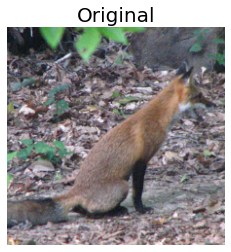

In [2]:
r50 = RandomMask(percent_missing=0.5, fixed = False)
r75 = RandomMask(percent_missing=0.75, fixed = False)
r90 = RandomMask(percent_missing=0.90, fixed = False)

blur21 = transforms.GaussianBlur(kernel_size=21, sigma=5)
blur37 = transforms.GaussianBlur(kernel_size=37, sigma=9)

noise01 = GaussianNoise(std=0.1, fixed=False)
noise03 = GaussianNoise(std=0.3, fixed=False)
noise05 = GaussianNoise(std=0.5, fixed=False)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

val_dataset = ImageNet100(
    root='/home/sriram/Projects/Datasets/ImageNet100',
    split = 'train',
    transform = transform
)

val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=24,\
                            pin_memory=True, shuffle=True)

pic = next(iter(val_dataloader))[0][0]
plt.figure()
plt.axis('off')
plt.title("Original", fontsize=20)
plt.imshow(pic.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


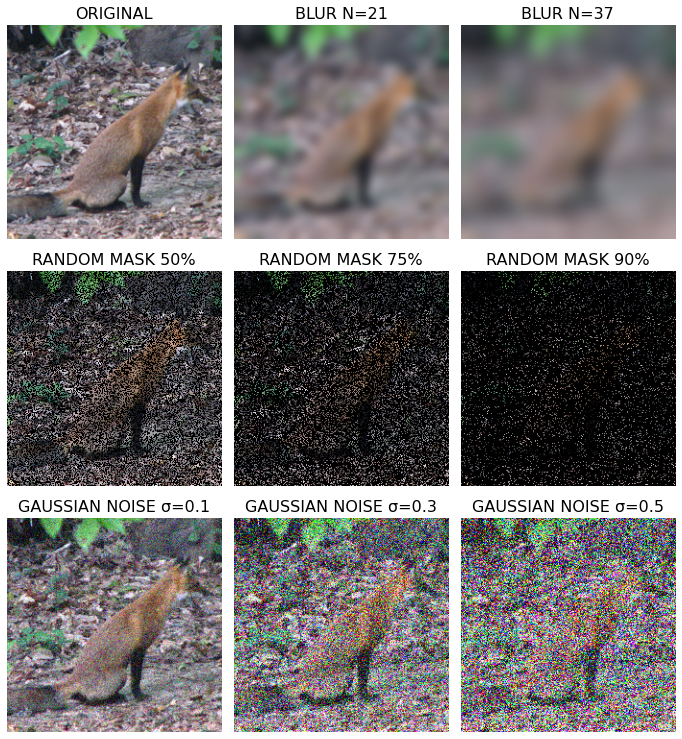

In [3]:
rand50 = r50(pic)
rand75 = r75(pic)
rand90 = r90(pic)

b21 = blur21(pic)
b37 = blur37(pic)

n01 = noise01(pic)
n03 = noise03(pic)
n05 = noise05(pic)

imgs = [pic, b21, b37, rand50, rand75, rand90, n01, n03, n05]
labels = ["ORIGINAL", "BLUR N=21", "BLUR N=37", "RANDOM MASK 50%", \
          "RANDOM MASK 75%", "RANDOM MASK 90%", "GAUSSIAN NOISE σ=0.1", "GAUSSIAN NOISE σ=0.3", "GAUSSIAN NOISE σ=0.5"]

_, axs = plt.subplots(3, 3, figsize=(12, 13))
plt.subplots_adjust(wspace=0.05, hspace=0.15)
axs = axs.flatten()
i=0
for img, ax in zip(imgs, axs):
    ax.imshow(img.permute(1, 2, 0))
    ax.title.set_text(labels[i])
    ax.title.set_size(16)
    ax.axis('off')
    i = i +1
plt.show()

# Evaluation of Baseline and LinearProbe on Random Mask 90%

## Here is a small evaluation script to run testing on the Baseline and LinearProbe models. Make sure to import the checkpoints, as described in the README, as well as have CUDA enabled in your system. Change the path to the checkpoints and the ImageNet-100 dataset as needed.

In [4]:
from pytorch_lightning import Trainer
from baselines import Baseline
from linear_probe import LinearProbe

baseline_file = '../rand90_baseline.ckpt'
linear_file = '../rand90_linear.ckpt'

normalize_resnet = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

transform_baseline = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    RandomMask(percent_missing=0.90, fixed = False),
    normalize_resnet
])

val_dataset_baseline = ImageNet100(
    root='/home/sriram/Projects/Datasets/ImageNet100',
    split = 'val',
    transform = transform_baseline
)


test_dataloader_baseline = DataLoader(val_dataset_baseline, batch_size=128, num_workers=24,\
                            pin_memory=True, shuffle=False)

trainer = Trainer(gpus=1)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [5]:
normalize_clip = transforms.Normalize(
    mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]
)

transform_clip = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    RandomMask(percent_missing=0.90, fixed = False),
    normalize_clip
])

val_dataset_clip = ImageNet100(
    root='/home/sriram/Projects/Datasets/ImageNet100',
    split = 'val',
    transform = transform_clip
)

test_dataloader_clip = DataLoader(val_dataset_clip, batch_size=128, num_workers=24,\
                            pin_memory=True, shuffle=False)

In [6]:
baseline_model = Baseline.load_from_checkpoint(baseline_file)
trainer.test(baseline_model, test_dataloaders=test_dataloader_baseline)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_top_1': 0.718999981880188, 'test_top_5': 0.9139999747276306}
--------------------------------------------------------------------------------


[{'test_top_1': 0.718999981880188, 'test_top_5': 0.9139999747276306}]

### Some hacks to make the models work with a different file system

### Change the filepath in the second line to point to the file rand90_zeroshot.ckpt wherever you downlaoded it

### Change the filepath in the third and fourth lines to be the location you wish to save the new, proper checkpoints

In [7]:
linear_ckpt = torch.load(linear_file)
linear_ckpt['hyper_parameters']['checkpoint_path'] = '../rand90_zeroshot.ckpt'
torch.save(linear_ckpt, f='../linear_rand90.ckpt')
linear_file = '../linear_rand90.ckpt'

In [8]:
linear_model = LinearProbe.load_from_checkpoint(linear_file)
trainer.test(linear_model, test_dataloaders=test_dataloader_clip)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_top_1': 0.7853999733924866, 'test_top_5': 0.9472000002861023}
--------------------------------------------------------------------------------


[{'test_top_1': 0.7853999733924866, 'test_top_5': 0.9472000002861023}]